# Effettuare una diagnosi di diabete in base allo stile di vita del paziente
## Progetto di Programmazione di Applicazioni Data Intensive
*Alessandro Ronchi 0001071042*

## Obiettivo

L'obiettivo del progetto è individuare la presenza di diabete in determinati pazienti, a partire da informazioni riguardanti il loro stile di vita.

I dati utilizzati provengono dal dataset "CDC Diabetes Health Indicators", fornito dal CDC (U.S. Centers for Disease Control and Prevention). Questo dataset contiene i dati ottenuti da un questionario effettuato nel 2015 su diversi cittadini americani con l'obiettivo di capire la correlazione tra stile di vita e incidenza del diabete.

L'obiettivo del progetto è dunque sviluppare un modello che sappia classificare le condizioni di salute di un dato paziente come "sano" o "diabetico", a partire dalle informazioni generali sul suo stile di vita.

**NOTA:** Un requisito importante del modello da sviluppare è la minimizzazione del numero di falsi negativi. Infatti, un modello troppo ottimistico, che tende a classificare la maggior parte dei pazienti come sani, non è adeguato in un contesto di diagnosi medica. Nel corso del progetto, quindi, ci concentreremo sul far sì che il modello abbia un'accuratezza elevata sui pazienti diabetici, in modo da avere un numero ridotto di falsi negativi.

## Importazione delle librerie

Innanzitutto, importiamo le librerie necessarie per analizzare i dati.

In [1]:
# librerie utilizzate
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

## Analisi Esplorativa dei dati

Cominciamo con l'importazione del dataset da analizzare e visualizziamo la sua struttura.

In [2]:
from os import path
from urllib.request import urlretrieve
from zipfile import ZipFile

DATASET_URL = "https://www.kaggle.com/api/v1/datasets/download/alexteboul/diabetes-health-indicators-dataset"

DATASET_ZIP = "cdc_diabetes_dataset.zip"
DATASET_DIR = "cdc_diabetes_dataset"

# Scarica lo zip dal repository di Kaggle
if not path.exists(DATASET_ZIP):
    urlretrieve(DATASET_URL, DATASET_ZIP)

# Estrae lo zip
if not path.exists(DATASET_DIR):
    zf = ZipFile(DATASET_ZIP, "r")
    zf.extractall(DATASET_DIR)

cdcdata = pd.read_csv(path.join(DATASET_DIR, "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"))

In [3]:
cdcdata

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


Per ogni paziente il dataset contiene le seguenti variabili:
- `Diabetes_binary` Variabile target da predire, che indica lo stato di salute del paziente con un valore binario: 0 indica "sano", 1 corrisponde a "diabetico"
- `HighBP` Variabile binaria che indica se il paziente ha una pressione sanguigna elevata
- `HighChol` Variabile binaria che indica se il paziente ha un livello di colesterolo elevato
- `CholCheck` Variabile binaria che indica se il paziente ha effettuato un controllo sul colesterolo negli ultimi 5 anni
- `BMI` Indice di massa corporea
- `Smoker` Variabile binaria che indica se il paziente è un fumatore (ha fumato almeno 100 sigarette nella sua vita)
- `Stroke` Variabile binaria che indica se il paziente ha avuto un ictus in passato
- `HeartDiseaseorAttack` Variabile binaria che indica se il paziente ha problemi cardiovascolari
- `PhysActivity` Variabile binaria che indica se il paziente ha svolto attività fisica negli ultimi 30 giorni
- `Fruits` Variabile binaria che indica se il paziente consuma frutta almeno una volta al giorno
- `Veggies` Variabile binaria che indica se il paziente consuma verdura almeno una volta al giorno
- `HvyAlcoholConsump` Variabile binaria che indica se il paziente assume molto alcool
- `AnyHealthcare` Variabile binaria che indica se il paziente ha una copertura assicurativa
- `NoDocbcCost` Variabile binaria che indica se il paziente ha avuto la necessità di una visita medica nell'ultimo anno, ma non ha potuto a causa del costo
- `GenHlth` Grado di salute generale del paziente (da 1 a 5)
- `MentHlth` Numero di giorni nell'ultimo mese in cui la salute mentale del paziente era compromessa
- `PhysHlth` Numero di giorni nell'ultimo mese in cui la salute fisica del paziente era compromessa
- `DiffWalk` Variabile binaria che indica se il paziente ha difficoltà a camminare o salire le scale
- `Sex` Sesso del paziente (0 = femmina, 1 = maschio)
- `Age` Fascia di età del paziente, rappresentata con un numero da 1 a 13, dove 1 corrisponde alla fascia 18-24 e le fasce successive hanno un'ampiezza di 5 anni, ad eccezione della 13, che corrisponde a "80 o più"
- `Education` Livello di istruzione del paziente, in una scala crescente da 1 a 6
- `Income` Reddito del paziente, in una scala da 1 a 8

Visualizziamo la quantità di memoria occupata dal dataset

In [4]:
cdcdata.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

Pandas di default utilizza un float64 per tutte le variabili, ma il dataset contiene solo variabili intere e binarie. Sarà quindi opportuno modificare in modo appropriato il tipo di ogni colonna, in modo da ottimizzare l'utilizzo della memoria.

In [5]:
bool_variables = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
    "Sex"
]

int_variables = [
    "BMI",
    "GenHlth",
    "MentHlth",
    "PhysHlth",
    "Age",
    "Education",
    "Income"
]

for var in bool_variables:
    cdcdata[var] = cdcdata[var].astype(bool)

for var in int_variables:
    cdcdata[var] = cdcdata[var].astype(int)

In [6]:
cdcdata.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  bool   
 2   HighChol              70692 non-null  bool   
 3   CholCheck             70692 non-null  bool   
 4   BMI                   70692 non-null  int32  
 5   Smoker                70692 non-null  bool   
 6   Stroke                70692 non-null  bool   
 7   HeartDiseaseorAttack  70692 non-null  bool   
 8   PhysActivity          70692 non-null  bool   
 9   Fruits                70692 non-null  bool   
 10  Veggies               70692 non-null  bool   
 11  HvyAlcoholConsump     70692 non-null  bool   
 12  AnyHealthcare         70692 non-null  bool   
 13  NoDocbcCost           70692 non-null  bool   
 14  GenHlth               70692 non-null  int32  
 15  MentHlth           

Modificando i tipi delle variabili, la quantità di memoria occupata dal dataset si è ridotta considerevolmente, arrivando a circa un quarto di quella originale.

Per quanto riguarda la variabile Diabetes_binary, potremmo convertirla per comodità da una variabile binaria ad una variabile categorica più espressiva, che ci faccia capire immediatamente il significato della classe di appartenenza. In particolare, sostituiremo il valore 0 con la label "S", che sta per "sano", e il valore 1 con la label "D", che sta per "diabetico".

In [7]:
label_map = {
    0:"S",
    1:"D"
}
cdcdata["Diabetes_binary"] = cdcdata["Diabetes_binary"].map(label_map).astype("category")
cdcdata["Diabetes_binary"]

0        S
1        S
2        S
3        S
4        S
        ..
70687    D
70688    D
70689    D
70690    D
70691    D
Name: Diabetes_binary, Length: 70692, dtype: category
Categories (2, object): ['D', 'S']

In [8]:
cdcdata.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Diabetes_binary       70692 non-null  category
 1   HighBP                70692 non-null  bool    
 2   HighChol              70692 non-null  bool    
 3   CholCheck             70692 non-null  bool    
 4   BMI                   70692 non-null  int32   
 5   Smoker                70692 non-null  bool    
 6   Stroke                70692 non-null  bool    
 7   HeartDiseaseorAttack  70692 non-null  bool    
 8   PhysActivity          70692 non-null  bool    
 9   Fruits                70692 non-null  bool    
 10  Veggies               70692 non-null  bool    
 11  HvyAlcoholConsump     70692 non-null  bool    
 12  AnyHealthcare         70692 non-null  bool    
 13  NoDocbcCost           70692 non-null  bool    
 14  GenHlth               70692 non-null  int32   
 15  Me

Così facendo, abbiamo inoltre ridotto ulteriormente le dimensioni in memoria del nostro dataset.

Iniziamo ad analizzare il dataset, visualizzando statistiche generali sulle variabili numeriche:

In [9]:
cdcdata.describe()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,29.856985,2.837082,3.752037,5.810417,8.584055,4.920953,5.698311
std,7.113954,1.113565,8.155627,10.062261,2.852153,1.029081,2.175196
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,25.000000,2.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,29.000000,3.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,33.000000,4.000000,2.000000,6.000000,11.000000,6.000000,8.000000
max,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


Visualizziamo in un grafico a torta la distribuzione delle 2 classi da predire:

<Axes: ylabel='count'>

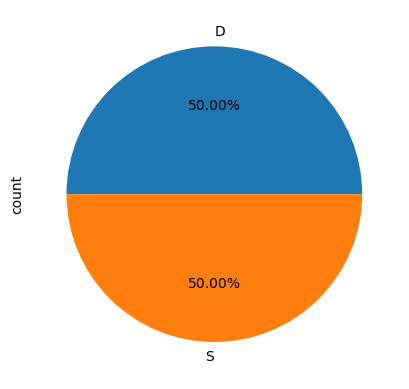

In [10]:
cdcdata["Diabetes_binary"].value_counts().plot.pie(autopct="%.2f%%")

Possiamo vedere come il dataset sia bilanciato, quindi non ci dovremo occupare di effettuare un bilanciamento con tecniche di undersampling o oversampling.

Controlliamo la presenza di eventuali valori mancanti nel dataset:

In [11]:
cdcdata.isna().any()

Diabetes_binary         False
HighBP                  False
HighChol                False
CholCheck               False
BMI                     False
Smoker                  False
Stroke                  False
HeartDiseaseorAttack    False
PhysActivity            False
Fruits                  False
Veggies                 False
HvyAlcoholConsump       False
AnyHealthcare           False
NoDocbcCost             False
GenHlth                 False
MentHlth                False
PhysHlth                False
DiffWalk                False
Sex                     False
Age                     False
Education               False
Income                  False
dtype: bool

Il dataset non presenta valori mancanti.

Procediamo osservando la distribuzione dei dati relativi ad alcune feature del dataset.

Vediamo innanzitutto la distribuzione dell'indice di massa corporea (BMI).

<Axes: ylabel='Frequency'>

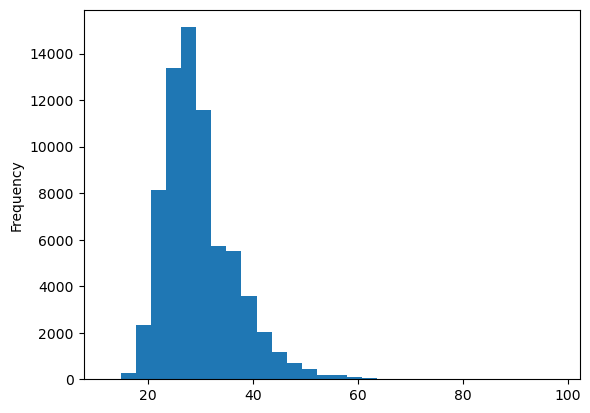

In [12]:
cdcdata["BMI"].plot.hist(bins=30)

<Axes: >

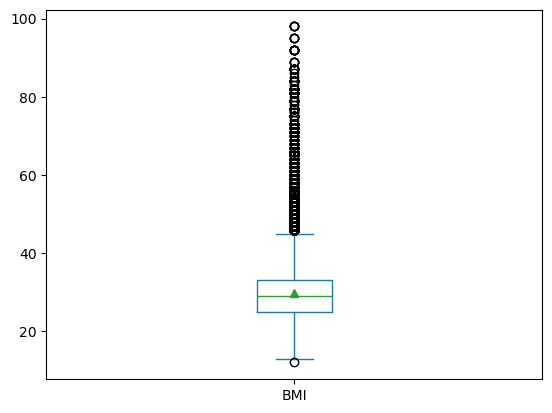

In [13]:
cdcdata["BMI"].plot.box(showmeans=True)

Possiamo vedere come la maggior parte dei pazienti ha un BMI compreso tra 20 e 40, con una distribuzione gaussiana. Esistono però istanze con valori di BMI superiori a 40, e che arrivano anche a valori di 80 o vicini al 100.

Vediamo la distribuzione dei pazienti per fasce di età:

<Axes: xlabel='Age'>

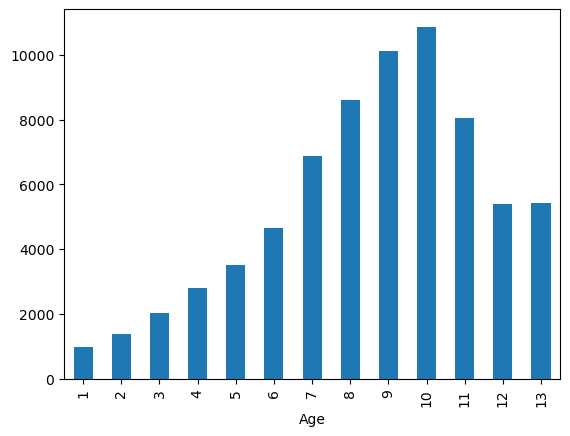

In [14]:
cdcdata["Age"].value_counts().sort_index().plot.bar()

La distribuzione delle fasce di età risulta più omogenea, ma con un numero di istanze maggiore per le fasce dalla 7 alla 10.

Proviamo a visualizzare su un grafico a dispersione i dati sulla classe di appartenenza in base a fascia di età e indice di massa corporea.

Distinguiamo le classi per colore, indicando in rosso i diabetici, arancione i prediabetici e in blu i pazienti sani.

<Axes: xlabel='BMI', ylabel='Age'>

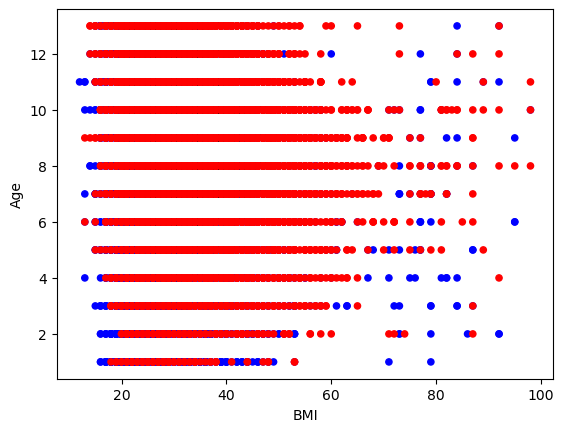

In [15]:
class_color_map = {"S":"blue", "D":"red"}
class_color = cdcdata["Diabetes_binary"].map(class_color_map)
cdcdata.plot.scatter("BMI", "Age", c=class_color)

Apparentemente, l'età è un fattore determinante per l'incidenza del diabete, con la maggior parte di casi concentrata nelle fasce di età più alte.

Proviamo a verificarlo mostrando in un istogramma la correlazione tra età e diagnosi:

<Axes: ylabel='Frequency'>

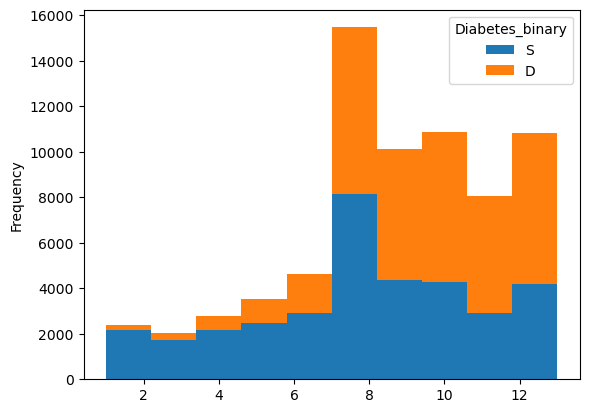

In [16]:
cdcdata.pivot_table(index=cdcdata.index, columns="Diabetes_binary", values="Age", observed=False).reindex(["S", "D"], axis=1).plot.hist(stacked=True)

Vediamo infatti come le fasce di età più alte hanno in proporzione un numero di casi positivi maggiore rispetto alle fasce più giovani. Tuttavia, questo potrebbe essere dovuto in parte anche al fatto che le fasce più giovani sono meno rappresentate. La successiva analisi dei pesi dei modelli considerati ci dirà se effettivamente si ha questa correlazione.

Analizziamo ora la distribuzione delle variabili binarie:

<Axes: >

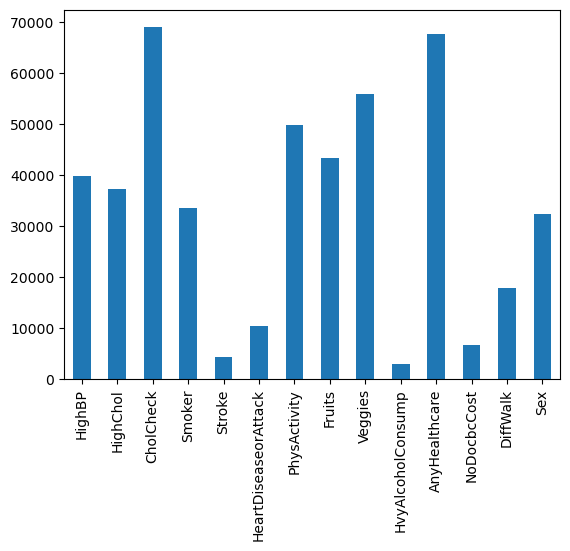

In [17]:
cdcdata[bool_variables].sum().plot.bar()

Possiamo notare come alcune variabili binarie hanno lo stesso valore per la maggior parte delle istanze, come `CholCheck`, `AnyHealthcare`, `Stroke` e `HvyAlcoholConsump`. Nel corso della fase di addestramento dei modelli, ci si può aspettare che queste variabili risultino meno rilevanti per la classificazione delle istanze.

## Preprocessing dei dati

Effettuata l'analisi sui dati, procediamo a prepararli per l'addestramento di un modello.

Innanzitutto, isoliamo la variabile target da predire, `Diabetes_binary`

In [18]:
y = cdcdata["Diabetes_binary"]
X = cdcdata.drop(columns=["Diabetes_binary"])

Isolata la variabile da predire, possiamo effettuare la divisione del dataset in training set e test set, inserendo 1/3 delle istanze nel test set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

Le variabili del dataset presentano solo variabili intere o binarie, che possono essere usate direttamente nell'addestramento di un modello. Non è quindi necessario effettuare ulteriori operazioni di preprocessing.

## Addestramento dei modelli

Nel corso della fase di addestramento dei modelli considerati, utilizzeremo una GridSearch per valutare, per ciascun modello, le combinazioni di iperparametri migliori. La GridSearch verrà inoltre applicata ad una K-Fold Cross Validation. Come algoritmo di K-Fold, si è scelto di utilizzare StratifiedKFold, in modo che la distribuzione delle classi sia costante su tutti i fold.

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [21]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)

Importiamo anche le funzioni di scikit-learn per il calcolo delle metriche di classificazione:

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, make_scorer, accuracy_score

Definiamo inoltre una serie di funzioni utili per visualizzare le statistiche dei classificatori, tra cui matrice di confusione, misure di precision e recall per ciascuna classe ed f1 measure.

In [23]:
def show_confusion_matrix(y, y_pred, classes):
    cm = confusion_matrix(y, y_pred)
    return pd.DataFrame(cm, index=classes, columns=classes)

In [24]:
def show_cv_results(gs):
    return pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

In [25]:
def show_recall_precision(y, y_pred, classes):
    score_matrix = np.zeros((classes.size, 2))

    for i in range(classes.size):
        score_matrix[i, 0] = precision_score(y, y_pred, pos_label=classes[i])
        score_matrix[i, 1] = recall_score(y, y_pred, pos_label=classes[i])

    return pd.DataFrame(score_matrix, index=classes, columns=["Precision", "Recall"])

La funzione seguente definisce la metrica che verrà usata per la valutazione dei modelli nel corso della GridSearch. In particolare, utilizziamo la F1 measure relativa alla classe dei diabetici, in quanto vogliamo che le predizioni del modello risultino accurate su questa classe. La scelta della F1 measure invece dell'accuratezza per la valutazione dei modelli è stata fatta perché la F1 measure è una misura più attendibile, in quanto tiene conto anche di precision e recall della classe considerata.

In [26]:
def f1_decision_scoring():
    """
    Definisce lo score f1 da utilizzare per la GridSearch
    """
    return make_scorer(f1_score, pos_label="D")

Definiamo anche una funzione per mostrare in un dataframe i pesi di un modello specificato.

In [27]:
def show_model_weights(model, model_name, index):
    """
    Mostra i pesi del modello specificato, mettendoli in un data frame con l'indice passato in input.
    """
    return pd.DataFrame(model.named_steps[model_name].coef_[0], index=index)

### Perceptron

Iniziamo con il modello più semplice: il Perceptron. Questo modello verrà testato con due diversi tipi di scaling, standard e MinMax.

In [28]:
from sklearn.linear_model import Perceptron

Definiamo la funzione che genera una GridSearch per un modello Perceptron.

In [29]:
def create_perc_model_gs():
    """
    Crea un modello di Perceptron con scaling.
    Ritorna la GridSearch che consente di addestrare il modello sui parametri specificati
    """
    perc_model = Pipeline([
        ("scale", None),
        ("perceptron", Perceptron(random_state=42))
    ])
    
    perc_grid = {
        "scale" : [None, StandardScaler(), MinMaxScaler()]
    }
    
    return GridSearchCV(perc_model, perc_grid, cv=skf, scoring=f1_decision_scoring())

Innanzitutto, addestriamo il modello sul dataset sbilanciato.

In [30]:
gs = create_perc_model_gs()
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', None),
                                       ('perceptron',
                                        Perceptron(random_state=42))]),
             param_grid={'scale': [None, StandardScaler(), MinMaxScaler()]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

Visualizziamo i risultati della ricerca, ordinati per rank del punteggio del modello.

In [31]:
show_cv_results(gs)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.073076,0.008471,0.044166,0.001411,StandardScaler(),{'scale': StandardScaler()},0.685306,0.634947,0.642069,0.637776,0.598398,0.639699,0.027632,1
2,0.061127,0.007983,0.044526,0.002548,MinMaxScaler(),{'scale': MinMaxScaler()},0.729169,0.710266,0.333165,0.745388,0.641593,0.631916,0.153505,2
0,0.064175,0.008140,0.037466,0.009256,None,{'scale': None},0.583424,0.730400,0.087694,0.747693,0.712318,0.572306,0.249130,3


In [32]:
gs.best_params_

{'scale': StandardScaler()}

Possiamo vedere come, sui dati sbilanciati, il modello ottiene i risultati migliori quando viene applicata la standardizzazione dei dati.

Vediamo quindi le metriche di valutazione di questo modello sul test set:

In [33]:
gs.score(X_test, y_test)

0.6275024295432459

In [34]:
y_pred = gs.predict(X_test)
show_confusion_matrix(y_test, y_pred, gs.classes_)

,D,S
D,6457,5325
S,2341,9441


Visualizziamo la F1 measure complessiva delle due classi:

In [35]:
f1_perc = f1_score(y_test, y_pred, average="macro")
f1_perc

0.6693712238118519

In [36]:
show_recall_precision(y_test, y_pred, gs.classes_)

,Precision,Recall
D,0.733917,0.548039
S,0.639374,0.801307


I punteggi di questo modello non sono male, ma si può fare di meglio. In particolare, vediamo che la recall per la classe dei diabetici è piuttosto ridotta, e ciò porta ad un numero elevato di falsi negativi.

### Logistic Regression

Passiamo ora ad un modello più avanzato: la Logistic Regression.

Per addestrare questo modello, oltre allo scaling, andremo a considerare anche l'introduzione di meccanismi di regolarizzazione l1, l2 ed elasticnet.

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
def create_logreg_model_gs(class_weight=None):
    """
    Crea un modello di Logistic Regression con scaling, bilanciamento del peso delle classi e regolarizzazione.
    Ritorna la GridSearch che consente di addestrare il modello sui parametri specificati.
    """
    model = Pipeline([
        ("scaler", None),
        ("logreg", LogisticRegression(solver="saga", random_state=42, class_weight=class_weight))
    ])

    grid = [        
        {
            "scaler":[None, StandardScaler()],
            "logreg__penalty":["l1", "l2"],
            "logreg__C": np.logspace(-2, 2, 4)
        },
        {
            "scaler":[None, StandardScaler()],
            "logreg__penalty":["elasticnet"],
            "logreg__C": np.logspace(-2, 2, 4),
            "logreg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
        }
    ]
    
    return GridSearchCV(model, grid, cv=skf, scoring=f1_decision_scoring())

In [39]:
logreg = create_logreg_model_gs()
logreg.fit(X_train, y_train)

C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: Con

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid=[{'logreg__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                          'logreg__penalty': ['l1', 'l2'],
                          'scaler': [None, StandardScaler()]},
                         {'logreg__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                          'logreg__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                          'logreg__penalty': ['elasticnet'],
                          'scaler': [None, StandardScaler()]}],
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [40]:
show_cv_results(logreg).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__penalty,param_scaler,param_logreg__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.252187,0.019269,0.060490,0.001889,0.01,elasticnet,StandardScaler(),0.75,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.75, ...",0.755242,0.752463,0.748880,0.754908,0.751977,0.752694,0.002302,1
21,0.261102,0.008774,0.058102,0.003785,0.01,elasticnet,StandardScaler(),0.5,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.5, '...",0.755238,0.751965,0.748984,0.755193,0.751898,0.752656,0.002351,2
19,0.251831,0.020070,0.062328,0.001507,0.01,elasticnet,StandardScaler(),0.25,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.25, ...",0.755394,0.751728,0.748437,0.755298,0.751977,0.752567,0.002591,3
25,0.239398,0.006513,0.059970,0.003621,0.01,elasticnet,StandardScaler(),0.9,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.9, '...",0.755242,0.751415,0.749063,0.754471,0.751845,0.752407,0.002226,4
17,0.240019,0.021874,0.059959,0.008915,0.01,elasticnet,StandardScaler(),0.1,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.1, '...",0.755108,0.751309,0.748984,0.754136,0.752211,0.752350,0.002155,5


Vediamo il punteggio di questo modello sul test set:

In [41]:
logreg.score(X_test, y_test)

0.7537638422296877

In [42]:
y_pred = logreg.predict(X_test)
f1_logreg = f1_score(y_test, y_pred, average="macro")
f1_logreg

0.7479120292957536

In [43]:
show_confusion_matrix(y_test, y_pred, logreg.classes_)

,D,S
D,9087,2695
S,3242,8540


In [44]:
show_recall_precision(y_test, y_pred, logreg.classes_)

,Precision,Recall
D,0.737043,0.771261
S,0.760125,0.724834


Grazie alla LogisticRegression, otteniamo risultati migliori. Infatti, vediamo che la F1 measure complessiva si è alzata fino a circa 0.75, ed è migliorata anche la recall sulla classe D.

In [45]:
logreg.best_params_

{'logreg__C': 0.01,
 'logreg__l1_ratio': 0.75,
 'logreg__penalty': 'elasticnet',
 'scaler': StandardScaler()}

Osservando gli iperparametri selezionati, vediamo che il modello ottiene i risultati migliori con una regolarizzazione di tipo elasticnet. In particolare, si ha un maggior peso sulla regolarizzazione L1 e un coefficiente C ridotto, che indica un elevato tasso di regolarizzazione. Grazie all'elevato tasso di regolarizzazione L1, ci aspettiamo che il modello abbia azzerato alcuni parametri, escludendo le relative variabili dalla valutazione delle istanze.

Possiamo verificarlo visualizzando in un dataframe i pesi del modello ottenuto:

In [46]:
logreg_weights = show_model_weights(logreg.best_estimator_, "logreg", X.columns)
logreg_weights

,0
HighBP,-0.359772
HighChol,-0.284273
CholCheck,-0.181748
BMI,-0.519018
Smoker,0.000000
Stroke,-0.038810
HeartDiseaseorAttack,-0.085694
PhysActivity,0.000000
Fruits,0.022157
Veggies,0.035694


In [47]:
logreg_weights.loc[logreg_weights[0] == 0]

,0
Smoker,0.0
PhysActivity,0.0
AnyHealthcare,0.0
NoDocbcCost,0.0


Vediamo infatti che il modello ha escluso le variabili `Smoker`, `PhysActivity`, `AnyHealthcare` e `NoDocbcCost`, ritenendole non rilevanti ai fini della classificazione.

In [48]:
logreg_weights.abs().sort_values(0, ascending=False).head(5)

,0
GenHlth,0.637399
BMI,0.519018
Age,0.420657
HighBP,0.359772
HighChol,0.284273


D'altra parte, il modello ha dato pesi con valori assoluti elevati alla salute generale dichiarata dal paziente (`GenHlth`), all'indice di massa corporea (`BMI`), all'età (`Age`), alla pressione sanguigna (`HighBP`) e alla presenza di colesterolo alto (`HighChol`). Queste variabili risultano quindi più rilevanti nella decisione.

Con la regressione logistica lineare abbiamo ottenuto dei buoni risultati. Vediamo però che risultati possiamo ottenere con un modello polinomiale.

### Polynomial Logistic Regression

Iniziamo con un modello polinomiale senza regolarizzazione, utilizzando polinomi di grado 2 o 3.

Il nostro dataset contiene un numero elevato di variabili binarie, sulle quali non ha senso elevare direttamente al quadrato o al cubo. Quindi, per limitare la quantità di feature polinomiali generate e mantenere solo quelle significative, settiamo a "True" il parametro "interaction_only" della classe PolynomialFeatures. In questo modo, verranno generate solo le feature polinomiali di interazione, che combinano una o più variabili, escludendo tutti i gli elevamenti a potenza diretti di una singola variabile.

Inoltre, visti i risultati ottenuti con la standardizzazione nel caso lineare, manteniamo la standardizzazione dei dati anche in questo modello.

In [49]:
from sklearn.preprocessing import PolynomialFeatures

In [50]:
def create_poly_logreg_gs(grid, class_weight=None):
    """
    Crea un modello di Logistic Regression con feature polinomiali.
    Ritorna la GridSearch che consente di addestrare il modello sui parametri specificati.
    """
    model = Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False, interaction_only=True)),
        ("logreg", LogisticRegression(solver="saga", random_state=42, class_weight=class_weight))
    ])

    return GridSearchCV(model, grid, cv=skf, scoring=f1_decision_scoring())

In [51]:
grid = {
    "poly__degree":[2, 3]
}
poly_logreg = create_poly_logreg_gs(grid)
poly_logreg.fit(X_train, y_train)

C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid={'poly__degree': [2, 3]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [52]:
show_cv_results(poly_logreg)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.586796,0.185245,0.068748,0.007656,2,{'poly__degree': 2},0.763866,0.759405,0.759372,0.761712,0.759967,0.760865,0.001726,1
1,44.225646,0.204086,0.159484,0.002668,3,{'poly__degree': 3},0.756878,0.746891,0.749280,0.755583,0.754001,0.752527,0.003815,2


In [53]:
poly_logreg.best_params_

{'poly__degree': 2}

La Grid Search ha selezionato il modello con le feature di grado 2. Vediamo il punteggio del modello sul test set:

In [54]:
poly_logreg.score(X_test, y_test)

0.7652456354039789

In [55]:
y_pred = poly_logreg.predict(X_test)
f1_poly_logreg = f1_score(y_test, y_pred, average="macro")
f1_poly_logreg

0.7541225065632216

In [56]:
show_confusion_matrix(y_test, y_pred, poly_logreg.classes_)

,D,S
D,9424,2358
S,3424,8358


In [57]:
show_recall_precision(y_test, y_pred, poly_logreg.classes_)

,Precision,Recall
D,0.733499,0.799864
S,0.779955,0.709387


L'aggiunta delle feature polinomiali ci ha consentito di aumentare leggermente le prestazioni del modello. Proviamo a vedere come sono stati assegnati i pesi:

In [58]:
coefs = poly_logreg.best_estimator_.named_steps["logreg"].coef_
coefs

array([[-3.52715681e-01, -2.93254830e-01, -2.37939332e-01,
        -5.32257037e-01,  1.10903707e-02, -7.57631474e-02,
        -1.71807501e-01,  5.04228482e-03,  2.53967181e-02,
         4.63789814e-02,  1.56194102e-01,  9.20884740e-03,
        -2.38394601e-02, -6.88951833e-01,  6.66888984e-02,
         1.08727090e-02, -8.36516386e-02, -1.13671832e-01,
        -3.81920193e-01,  3.34346736e-02,  1.44589756e-01,
        -3.35617695e-02, -1.10947691e-02,  3.76729456e-02,
         5.38421107e-03, -8.01507917e-03,  4.30493415e-02,
         2.58411678e-04, -1.13006841e-02, -1.09719404e-02,
         2.24869018e-02,  1.69060348e-02,  1.38026357e-02,
         5.91191927e-02, -1.05189597e-02, -4.10643569e-03,
        -2.54905556e-02,  3.36112502e-02,  6.09950312e-02,
        -2.21760778e-02,  8.84554032e-03,  1.35546224e-02,
         4.19146566e-02, -6.58631912e-03,  3.32801620e-02,
         4.93924311e-02,  9.11490836e-03, -9.06325147e-05,
        -2.69243947e-04, -4.21583659e-03,  2.36895898e-0

Vediamo che i pesi assegnati risultano piuttosto bassi in valore assoluto. Questo è un bene, in quanto il modello ha già trovato autonomamente una soluzione vicina all'origine, e dunque l'accuratezza del modello non è stata compromessa.

Proviamo comunque ad applicare una regolarizzazione di tipo elasticnet, per vedere come variano i pesi e le performance del modello.

In [59]:
grid = {
    "poly__degree":[2],
    "logreg__penalty":["elasticnet"],
    "logreg__C": np.logspace(-2, 2, 4),
    "logreg__l1_ratio": [0.25, 0.5, 0.75]
}
poly_logreg_elastnet = create_poly_logreg_gs(grid=grid)
poly_logreg_elastnet.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid={'logreg__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                         'logreg__l1_ratio': [0.25, 0.5, 0.75],
                         'logreg__penalty': ['elasticnet'],
                         'poly__degree': [2]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [60]:
show_cv_results(poly_logreg_elastnet)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__l1_ratio,param_logreg__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,1.702829,0.118153,0.073639,0.009244,0.01,0.5,elasticnet,2,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.5, '...",0.764171,0.759647,0.759008,0.764551,0.761730,0.761821,0.002264,1
0,1.810160,0.178077,0.075000,0.006250,0.01,0.25,elasticnet,2,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.25, ...",0.763362,0.760049,0.759359,0.764587,0.760500,0.761572,0.002032,2
2,1.801665,0.056099,0.071294,0.007260,0.01,0.75,elasticnet,2,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.75, ...",0.765001,0.759039,0.757966,0.763714,0.760351,0.761214,0.002706,3
3,2.615069,0.322933,0.073269,0.006747,0.215443,0.25,elasticnet,2,"{'logreg__C': 0.21544346900318834, 'logreg__l1...",0.763837,0.759045,0.759421,0.761885,0.760346,0.760907,0.001762,4
6,2.844242,0.297817,0.067985,0.006843,4.641589,0.25,elasticnet,2,"{'logreg__C': 4.6415888336127775, 'logreg__l1_...",0.763866,0.759405,0.759372,0.761712,0.759967,0.760865,0.001726,5
7,2.701769,0.276880,0.073215,0.007416,4.641589,0.5,elasticnet,2,"{'logreg__C': 4.6415888336127775, 'logreg__l1_...",0.763866,0.759405,0.759372,0.761712,0.759967,0.760865,0.001726,5
8,2.684354,0.267048,0.072076,0.006830,4.641589,0.75,elasticnet,2,"{'logreg__C': 4.6415888336127775, 'logreg__l1_...",0.763866,0.759405,0.759372,0.761712,0.759967,0.760865,0.001726,5
9,3.243896,0.375679,0.070248,0.006581,100.0,0.25,elasticnet,2,"{'logreg__C': 100.0, 'logreg__l1_ratio': 0.25,...",0.763866,0.759405,0.759295,0.761712,0.759841,0.760824,0.001753,8
10,3.187473,0.339731,0.072252,0.005113,100.0,0.5,elasticnet,2,"{'logreg__C': 100.0, 'logreg__l1_ratio': 0.5, ...",0.763866,0.759405,0.759295,0.761712,0.759841,0.760824,0.001753,8
11,3.072449,0.315626,0.072657,0.005397,100.0,0.75,elasticnet,2,"{'logreg__C': 100.0, 'logreg__l1_ratio': 0.75,...",0.763866,0.759405,0.759295,0.761712,0.759841,0.760824,0.001753,8


In [61]:
poly_logreg_elastnet.best_params_

{'logreg__C': 0.01,
 'logreg__l1_ratio': 0.5,
 'logreg__penalty': 'elasticnet',
 'poly__degree': 2}

La configurazione selezionata dalla GridSearch è quella con l1_ratio pari a 0.5, quindi con un peso bilanciato tra regolarizzazione L1 ed L2, e un C basso, e quindi regolarizzazione consistente. Vediamo il punteggio di questo modello:

In [62]:
poly_logreg_elastnet.score(X_test, y_test)

0.7652696556205328

In [63]:
y_pred = poly_logreg_elastnet.predict(X_test)
f1_poly_logreg_elastnet = f1_score(y_test, y_pred, average="macro")
f1_poly_logreg_elastnet

0.754213213874966

In [64]:
show_confusion_matrix(y_test, y_pred, poly_logreg_elastnet.classes_)

,D,S
D,9422,2360
S,3420,8362


In [65]:
show_recall_precision(y_test, y_pred, poly_logreg_elastnet.classes_)

,Precision,Recall
D,0.733686,0.799694
S,0.779892,0.709727


Pur introducendo la regolarizzazione, la F1 measure complessiva e le misure di precision e recall non sono aumentate particolarmente rispetto al caso precedente. Ciò era, tuttavia, prevedibile, dato che i pesi del modello senza regolarizzazione avevano già un valore assoluto piccolo. Tuttavia, se osserviamo i pesi di questo modello, vediamo che la regolarizzazione ha contribuito ad azzerare un buon numero di parametri:

In [66]:
poly_logreg_elastnet.best_estimator_.named_steps["logreg"].coef_[0]

array([-3.52152083e-01, -2.88070468e-01, -2.00125862e-01, -5.15928466e-01,
        0.00000000e+00, -6.31141893e-02, -1.53450502e-01,  7.51055618e-04,
        2.02549142e-02,  4.03652103e-02,  1.41929372e-01,  0.00000000e+00,
       -2.65280041e-03, -6.62055855e-01,  4.43667846e-02,  0.00000000e+00,
       -7.77096986e-02, -1.05192353e-01, -3.72653532e-01,  2.82454898e-02,
        1.39625077e-01, -2.08427174e-02,  0.00000000e+00,  2.60005166e-02,
        0.00000000e+00,  0.00000000e+00,  3.43977328e-02,  0.00000000e+00,
       -7.50608764e-03, -4.34276867e-03,  1.39512962e-02,  6.26193584e-03,
        1.06267178e-03,  4.69174584e-02, -4.94645854e-03,  0.00000000e+00,
       -1.23909774e-02,  2.98914647e-02,  5.38248207e-02, -1.44265121e-02,
        0.00000000e+00,  1.18431703e-03,  2.63643298e-02,  0.00000000e+00,
        2.33986612e-02,  4.27357644e-02,  3.56298746e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.01315575e-02,
        0.00000000e+00, -

### Decision Tree

Proviamo ora con un modello basato su un albero decisionale.

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text

In [68]:
def create_dec_tree_gs(grid, class_weight=None):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("dectree", DecisionTreeClassifier(random_state=42, class_weight=class_weight))
    ])
    
    return GridSearchCV(model, grid, cv=skf, scoring=f1_decision_scoring())

In questo caso, come iperparametri configuriamo la massima profondità dell'albero e la minima frazione di elementi del training set che ogni nodo intermedio deve contenere.

In [69]:
grid = {
    "dectree__max_depth":range(2, 12),
    "dectree__min_samples_split":[0.5, 0.10, 0.15, 0.2]
}

dec_tree = create_dec_tree_gs(grid)
dec_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('dectree',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dectree__max_depth': range(2, 12),
                         'dectree__min_samples_split': [0.5, 0.1, 0.15, 0.2]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [70]:
show_cv_results(dec_tree).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dectree__max_depth,param_dectree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,0.083401,0.006527,0.059376,6.251455e-03,9,0.15,"{'dectree__max_depth': 9, 'dectree__min_sample...",0.743044,0.740056,0.743745,0.74971,0.744006,0.744112,0.003133,1
22,0.085206,0.007139,0.061066,7.813282e-03,7,0.15,"{'dectree__max_depth': 7, 'dectree__min_sample...",0.743044,0.740056,0.743745,0.74971,0.744006,0.744112,0.003133,1
38,0.078333,0.000417,0.062501,8.395585e-07,11,0.15,"{'dectree__max_depth': 11, 'dectree__min_sampl...",0.743044,0.740056,0.743745,0.74971,0.744006,0.744112,0.003133,1
34,0.088603,0.006539,0.057612,6.268129e-03,10,0.15,"{'dectree__max_depth': 10, 'dectree__min_sampl...",0.743044,0.740056,0.743745,0.74971,0.744006,0.744112,0.003133,1
18,0.078990,0.005455,0.065579,4.176890e-03,6,0.15,"{'dectree__max_depth': 6, 'dectree__min_sample...",0.743044,0.740056,0.743745,0.74971,0.744006,0.744112,0.003133,1


In [71]:
dec_tree.best_params_

{'dectree__max_depth': 4, 'dectree__min_samples_split': 0.15}

Come possiamo vedere dal risultato della grid search, si hanno diverse configurazioni con lo stesso punteggio. Per mostrare i risultati, ci baseremo sul best estimator selezionato, con altezza massima di 4 e min samples split di 0.15.

In [72]:
dec_tree.score(X_test, y_test)

0.746851865984889

In [73]:
y_pred = dec_tree.predict(X_test)
f1_dec_tree = f1_score(y_test, y_pred, average="macro")
f1_dec_tree

0.7148846845458332

In [74]:
show_confusion_matrix(y_test, y_pred, dec_tree.classes_)

,D,S
D,9786,1996
S,4638,7144


In [75]:
show_recall_precision(y_test, y_pred, dec_tree.classes_)

,Precision,Recall
D,0.678453,0.830589
S,0.781619,0.606349


Dal punto di vista della F1 measure, l'albero decisionale ha ottenuto uno score leggermente più ridotto rispetto ai modelli con la Regressione Logistica (0.71 contro 0.75). Tuttavia, un risultato interessante è il fatto che la recall della classe D in questo modello sia maggiore rispetto a tutti gli altri modelli testati finora. Questo è un risultato positivo, perché indica che il modello ha una minore probabilità di generare falsi negativi. D'altro canto, questo aumento nella recall di D comporta un'abbassamento della precision, e quindi il modello tende a privilegiare la classe D, generando più falsi positivi rispetto agli altri modelli.

In [76]:
tree_model = dec_tree.best_estimator_.named_steps["dectree"]

Vediamo la struttura dell'albero decisionale sul modello addestrato:

[Text(0.4625, 0.9, 'HighBP <= -0.128\ngini = 0.5\nsamples = 47128\nvalue = [23564, 23564]'),
 Text(0.25, 0.7, 'GenHlth <= -0.297\ngini = 0.406\nsamples = 20574\nvalue = [5824, 14750]'),
 Text(0.15, 0.5, 'Age <= 0.324\ngini = 0.249\nsamples = 11584\nvalue = [1687.0, 9897.0]'),
 Text(0.1, 0.3, 'BMI <= -0.195\ngini = 0.187\nsamples = 8649\nvalue = [903, 7746]'),
 Text(0.05, 0.1, 'gini = 0.131\nsamples = 6161\nvalue = [434, 5727]'),
 Text(0.15, 0.1, 'gini = 0.306\nsamples = 2488\nvalue = [469, 2019]'),
 Text(0.2, 0.3, 'gini = 0.392\nsamples = 2935\nvalue = [784.0, 2151.0]'),
 Text(0.35, 0.5, 'Age <= -0.727\ngini = 0.497\nsamples = 8990\nvalue = [4137, 4853]'),
 Text(0.3, 0.3, 'gini = 0.421\nsamples = 2874\nvalue = [865, 2009]'),
 Text(0.4, 0.3, 'gini = 0.498\nsamples = 6116\nvalue = [3272, 2844]'),
 Text(0.675, 0.7, 'GenHlth <= -0.297\ngini = 0.444\nsamples = 26554\nvalue = [17740, 8814]'),
 Text(0.55, 0.5, 'BMI <= -0.054\ngini = 0.497\nsamples = 7325\nvalue = [3403.0, 3922.0]'),
 Text(0.5

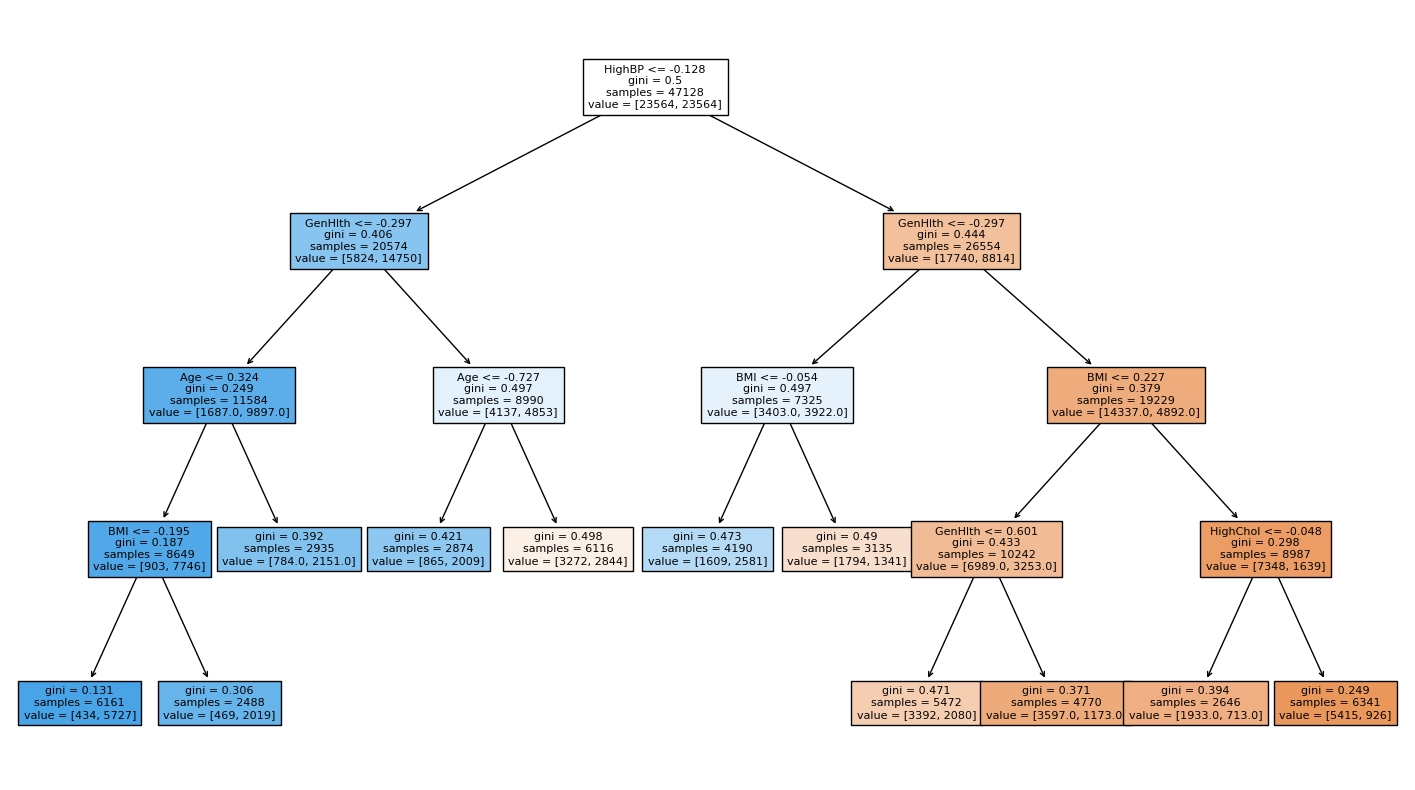

In [77]:
plt.figure(figsize=(18, 10))
plot_tree(tree_model, feature_names=X.columns.to_list(), filled=True, fontsize=8)

In [78]:
print(export_text(tree_model, feature_names=X.columns.to_list()))

|--- HighBP <= -0.13
|   |--- GenHlth <= -0.30
|   |   |--- Age <= 0.32
|   |   |   |--- BMI <= -0.19
|   |   |   |   |--- class: S
|   |   |   |--- BMI >  -0.19
|   |   |   |   |--- class: S
|   |   |--- Age >  0.32
|   |   |   |--- class: S
|   |--- GenHlth >  -0.30
|   |   |--- Age <= -0.73
|   |   |   |--- class: S
|   |   |--- Age >  -0.73
|   |   |   |--- class: D
|--- HighBP >  -0.13
|   |--- GenHlth <= -0.30
|   |   |--- BMI <= -0.05
|   |   |   |--- class: S
|   |   |--- BMI >  -0.05
|   |   |   |--- class: D
|   |--- GenHlth >  -0.30
|   |   |--- BMI <= 0.23
|   |   |   |--- GenHlth <= 0.60
|   |   |   |   |--- class: D
|   |   |   |--- GenHlth >  0.60
|   |   |   |   |--- class: D
|   |   |--- BMI >  0.23
|   |   |   |--- HighChol <= -0.05
|   |   |   |   |--- class: D
|   |   |   |--- HighChol >  -0.05
|   |   |   |   |--- class: D



Dall'output possiamo vedere come le feature su cui il modello si basa per effettuare le previsioni sono `HighBP`, `GenHlth`, `BMI`, `Age` e `HighChol`. Questa selezione di feature è coerente con quanto osservato per il modello di Logistic Regression con regolarizzazione.

In [79]:
pd.DataFrame(tree_model.feature_importances_, index=X.columns).sort_values(0, ascending=False).head(5)

,0
HighBP,0.562772
GenHlth,0.316261
BMI,0.057578
Age,0.054073
HighChol,0.009316


Stampando l'importanza delle feature scelte, ci accorgiamo che il modello dà particolare importanza a `HighBP` e `GenHlth`. Queste sono infatti le variabili usate per la decisione nei due livelli superiori dell'albero.

### Random Forest

Proviamo ora un metodo basato su una foresta di alberi decisionali: il Random Forest.

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
def create_rand_forest_gs(grid, class_weight=None):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("randforest", RandomForestClassifier(random_state=42, max_features="sqrt", n_jobs=-1, class_weight=class_weight))
    ])

    return GridSearchCV(model, grid, cv=skf, scoring=f1_decision_scoring())

In questo caso, oltre all'iperparametro "max_depth" già visto per il decision tree, consideriamo anche il numero di alberi nella foresta (n_estimators) e la massima frazione di istanze da utilizzare per addestrare ogni albero (max_samples).

In [82]:
max_depth_params = [i for i in range(5, 9)]
max_depth_params.append(None)

grid = {
    "randforest__n_estimators": [100, 200],
    "randforest__max_depth": max_depth_params,
    "randforest__max_samples": [0.1, 0.15, 0.2]
}

rand_forest = create_rand_forest_gs(grid)
%time rand_forest.fit(X_train, y_train)

CPU times: total: 3min 12s
Wall time: 1min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('randforest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'randforest__max_depth': [5, 6, 7, 8, None],
                         'randforest__max_samples': [0.1, 0.15, 0.2],
                         'randforest__n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [83]:
show_cv_results(rand_forest).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randforest__max_depth,param_randforest__max_samples,param_randforest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,0.471105,0.004455,0.101632,0.005742,None,0.15,200,"{'randforest__max_depth': None, 'randforest__m...",0.763270,0.760191,0.755610,0.763078,0.758558,0.760141,0.002880,1
25,0.477893,0.012731,0.108189,0.005355,None,0.1,200,"{'randforest__max_depth': None, 'randforest__m...",0.762465,0.756011,0.757410,0.761117,0.760291,0.759459,0.002390,2
26,0.272630,0.004877,0.079174,0.001196,None,0.15,100,"{'randforest__max_depth': None, 'randforest__m...",0.762591,0.757025,0.757282,0.760275,0.757838,0.759002,0.002132,3
19,0.435674,0.007928,0.100640,0.001898,8,0.1,200,"{'randforest__max_depth': 8, 'randforest__max_...",0.762952,0.752554,0.755258,0.762774,0.761006,0.758909,0.004228,4
18,0.258928,0.001130,0.078780,0.000366,8,0.1,100,"{'randforest__max_depth': 8, 'randforest__max_...",0.762515,0.753136,0.755285,0.762587,0.760392,0.758783,0.003876,5


In [84]:
rand_forest.best_params_

{'randforest__max_depth': None,
 'randforest__max_samples': 0.15,
 'randforest__n_estimators': 200}

In [85]:
rand_forest.score(X_test, y_test)

0.7632737109863932

In [86]:
y_pred = rand_forest.predict(X_test)
f1_rand_forest = f1_score(y_test, y_pred, average="macro")
f1_rand_forest

0.7505380674246844

In [87]:
show_confusion_matrix(y_test, y_pred, rand_forest.classes_)

,D,S
D,9452,2330
S,3533,8249


In [88]:
show_recall_precision(y_test, y_pred, rand_forest.classes_)

,Precision,Recall
D,0.727917,0.802241
S,0.779752,0.700136


Possiamo vedere come la Random Forest, senza un limite alla profondità degli alberi, 200 alberi e una percentuale di max_samples di 15%, raggiunge prestazioni simili alla Logistic Regression con feature polinomiali.

In [89]:
rand_forest_model = rand_forest.best_estimator_.named_steps["randforest"]
pd.DataFrame(rand_forest_model.feature_importances_, index=X.columns).sort_values(0, ascending=False)

,0
BMI,0.164709
Age,0.125056
GenHlth,0.110592
Income,0.084390
HighBP,0.077223
PhysHlth,0.065546
Education,0.056240
MentHlth,0.049645
HighChol,0.042049
Smoker,0.028557


Visualizando i pesi, vediamo come `HighBP`, `GenHlth`, `BMI` e `Age` rimangono le variabili più rilevanti nella classificazione delle istanze.

### XGBoost

Proviamo infine XGBoost, un metodo basato sul Gradient Boosting.

In [90]:
#%pip install xgboost

In [91]:
from xgboost import XGBClassifier
from xgboost import plot_importance

In [92]:
def create_xgboost_gs(grid, class_weight=None):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("xgboost", XGBClassifier(objective="binary:logistic", random_state=42))
    ])

    return GridSearchCV(model, grid, cv=skf, scoring="f1")

In questo caso consideriamo n_estimators e max_depth come per la Random Forest e specifichiamo anche l'iperparametro reg_alpha, che controlla la regressione L1.

In [93]:
grid = {
    "xgboost__n_estimators": [200, 300],
    "xgboost__max_depth": range(2, 5),
    "xgboost__reg_alpha": np.logspace(-3, 1, 3)
}

class_map = {
    "D":1,
    "S":0
}
y_train_xgb = y_train.map(class_map)
y_test_xgb = y_test.map(class_map)

xgboost = create_xgboost_gs(grid)
%time xgboost.fit(X_train, y_train_xgb)

CPU times: total: 5min 18s
Wall time: 20.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'xgboost__max_depth': range(2, 5),
                         'xgboost__n_estimators': [200, 300],
                         'xgboost__reg_alpha': array([1.e-03, 1.e-01, 1.e+01])},
             scoring='f1')

In [94]:
show_cv_results(xgboost).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgboost__max_depth,param_xgboost__n_estimators,param_xgboost__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.170022,0.007314,0.012501,6.250334e-03,3,200,10.0,"{'xgboost__max_depth': 3, 'xgboost__n_estimato...",0.766568,0.758191,0.757997,0.763254,0.762116,0.761625,0.003234,1
11,0.213949,0.006308,0.015626,1.181556e-06,3,300,10.0,"{'xgboost__max_depth': 3, 'xgboost__n_estimato...",0.766568,0.758191,0.757997,0.763254,0.762116,0.761625,0.003234,1
14,0.178539,0.008187,0.012500,6.249762e-03,4,200,10.0,"{'xgboost__max_depth': 4, 'xgboost__n_estimato...",0.765806,0.759231,0.757760,0.762059,0.763003,0.761572,0.002836,3
17,0.250378,0.042209,0.015040,7.589520e-04,4,300,10.0,"{'xgboost__max_depth': 4, 'xgboost__n_estimato...",0.765806,0.759231,0.757760,0.762059,0.763003,0.761572,0.002836,3
7,0.181457,0.007409,0.015624,6.810597e-07,3,200,0.1,"{'xgboost__max_depth': 3, 'xgboost__n_estimato...",0.765580,0.758656,0.757218,0.761779,0.763956,0.761438,0.003136,5


In [95]:
xgboost.best_params_

{'xgboost__max_depth': 3,
 'xgboost__n_estimators': 200,
 'xgboost__reg_alpha': 10.0}

Possiamo vedere come lo score più alto si ha con una regressione L1 piuttosto elevata.

In [96]:
xgboost.score(X_test, y_test_xgb)

0.7674004532211072

In [97]:
y_pred = xgboost.predict(X_test)
f1_xgboost = f1_score(y_test_xgb, y_pred)
f1_xgboost

0.7674004532211072

Questo modello è quello che ci ha restituito la F1 measure maggiore sul test set.

Nel visualizzare la matrice di confusione, ricordiamo che 0 = "S" e 1 = "D".

In [98]:
show_confusion_matrix(y_test_xgb, y_pred, xgboost.classes_)

,0,1
0,8334,3448
1,2300,9482


In [99]:
show_recall_precision(y_test_xgb, y_pred, xgboost.classes_)

,Precision,Recall
0,0.783713,0.707350
1,0.733333,0.804787


Possiamo vedere come si ha un buon valore di recall per la classe D (più di 0.8), ma senza compromettere le statistiche relative alla classe S. Quindi possiamo considerare soddisfacenti i risultati ottenuti con questo modello.

Visualizziamo ora l'importanza che il modello attribuisce a ciascuna feature:

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

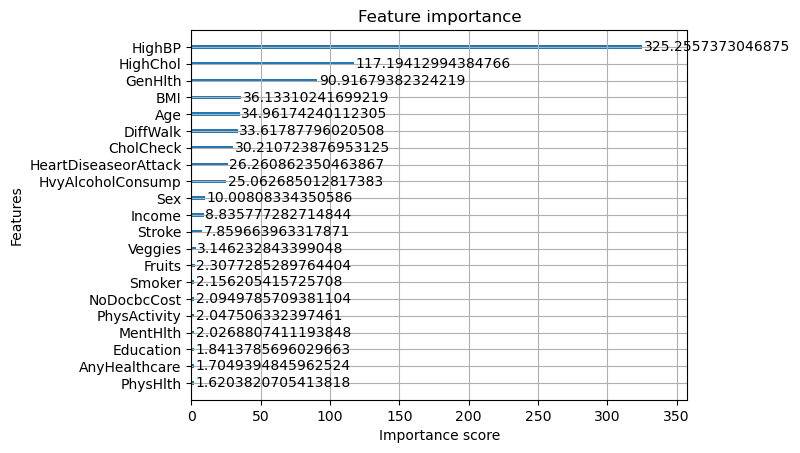

In [100]:
xgboost_model = xgboost.best_estimator_.named_steps["xgboost"]
xgboost_model.get_booster().feature_names = X.columns.to_list()
plot_importance(xgboost_model, importance_type="gain")

Anche in questo caso si riconferma l'importanza di `HighBP`, `GenHlth`, `BMI`, `Age` e `HighChol` per la valutazione delle istanze.

## Confronto tra i modelli

Confrontiamo ora gli score ottenuti dai vari modelli, visualizzando per ciascun modello anche i migliori iperparametri trovati:

In [101]:
model_names = [
    "Perceptron",
    "Logistic Regression",
    "Polynomial Logreg",
    "Polynomial Logreg Elasticnet",
    "Decision Tree",
    "Random Forest",
    "XGBoost"
]
model_scores = [
    f1_perc,
    f1_logreg,
    f1_poly_logreg,
    f1_poly_logreg_elastnet,
    f1_dec_tree,
    f1_rand_forest,
    f1_xgboost
]
best_params = [
    gs.best_params_,
    logreg.best_params_,
    poly_logreg.best_params_,
    poly_logreg_elastnet.best_params_,
    dec_tree.best_params_,
    rand_forest.best_params_,
    xgboost.best_params_
]

rank_data = {
    "f1 measure": model_scores,
    "best params":best_params
}

model_rank = pd.DataFrame(rank_data, columns=["f1 measure", "best params"], index=model_names)
model_rank.sort_values("f1 measure", ascending=False)

,f1 measure,best params
XGBoost,0.767400,"{'xgboost__max_depth': 3, 'xgboost__n_estimato..."
Polynomial Logreg Elasticnet,0.754213,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.5, '..."
Polynomial Logreg,0.754123,{'poly__degree': 2}
Random Forest,0.750538,"{'randforest__max_depth': None, 'randforest__m..."
Logistic Regression,0.747912,"{'logreg__C': 0.01, 'logreg__l1_ratio': 0.75, ..."
Decision Tree,0.714885,"{'dectree__max_depth': 4, 'dectree__min_sample..."
Perceptron,0.669371,{'scale': StandardScaler()}


I modelli che hanno restituito le misure migliori di f1 measure sono XGBoost, Regressione Logistica Polinomiale e Random Forest. Su questi 3 modelli, può essere utile calcolare l'intervallo di confidenza dell'accuratezza, in modo da avere un'indicazione più precisa sulle prestazioni attese in un dataset qualsiasi.

Innanzitutto definiamo la funzione per il calcolo dell'intervallo di confidenza:

In [102]:
def calc_accuracy_interval(confidence, accuracy, N):
    import scipy.stats as st
    Z = st.norm.ppf((1 + confidence) / 2)
    den = 2 * (N + Z**2)
    int_center = 2*N*accuracy + Z**2
    int_len = Z * np.sqrt(Z**2 + 4*N*accuracy * (1 - accuracy))
    Pmin = (int_center - int_len) / den
    Pmax = (int_center + int_len) / den
    interval = np.array([Pmin, Pmax])
    print("Accuracy interval: ", interval)

Calcoliamo ora l'intervallo sui 3 modelli migliori, fissando una confidenza del 95%.

In [103]:
confidence = 0.95
N = y_test.count()

**Regressione Logistica Polinomiale con Elasticnet:**

In [104]:
y_pred_logreg = poly_logreg_elastnet.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_logreg)
calc_accuracy_interval(confidence, accuracy, N)

Accuracy interval:  [0.7491758  0.76016232]


**Random Forest:**

In [105]:
y_pred_rand_forest = rand_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rand_forest)
calc_accuracy_interval(confidence, accuracy, N)

Accuracy interval:  [0.74562768 0.75666694]


**XGBoost:**

In [106]:
y_pred_xgb = xgboost.predict(X_test)
accuracy = accuracy_score(y_test_xgb, y_pred_xgb)
calc_accuracy_interval(confidence, accuracy, N)

Accuracy interval:  [0.75054388 0.7615098 ]


## Osservazioni sulla conoscenza appresa dai modelli

I test effettuati sui vari modelli hanno permesso di ottenere informazioni su quali feature del dataset siano più o meno importanti per il task di classificazione.

In particolare, si è osservato che la maggior parte dei modelli danno un peso elevato alle seguenti 5 feature:
- `HighBP`
- `GenHlth`
- `BMI`
- `Age`
- `HighChol`

Possiamo quindi affermare che queste 5 sono le feature più rilevanti per classificare le istanze del dataset.

Per quanto riguarda le feature meno rilevanti, la maggior parte dei modelli dà un peso molto ridotto alle seguenti variabili:
- `AnyHealthcare`
- `Smoker`
- `NoDocbcCost`

Queste variabili risultano poco rilevanti per la classificazione, e potrebbero essere escluse dal dataset.

## Prova con dataset sbilanciato

Il dataset utilizzato finora è un dataset bilanciato, ricavato dal dataset originale applicando una tecnica di bilanciamento. Proviamo ora a caricare il dataset originale, che presenta la distribuzione delle classi effettivamente riscontrata durante il questionario.

In [107]:
cdcdata_unbalanced_orig = pd.read_csv(path.join(DATASET_DIR, "diabetes_binary_health_indicators_BRFSS2015.csv"))

In [108]:
cdcdata_unbalanced_orig

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


Questo dataset è particolarmente voluminoso, quindi per ridurre i tempi di esecuzione, selezioneremo solo 70.000 istanze in modo casuale.

In [109]:
cdcdata_unb = cdcdata_unbalanced_orig.sample(70_000, random_state=42)
cdcdata_unb

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
219620,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,3.0,7.0,0.0,0.0,7.0,4.0,2.0
132821,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,6.0,6.0
151862,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,7.0
139717,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,4.0,7.0
239235,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,4.0,27.0,27.0,1.0,0.0,8.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242687,0.0,0.0,0.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0,4.0,7.0
178402,1.0,1.0,1.0,1.0,31.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,4.0,0.0,30.0,0.0,1.0,9.0,4.0,2.0
54668,0.0,0.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,30.0,30.0,0.0,0.0,8.0,6.0,6.0
188493,0.0,1.0,0.0,1.0,33.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,5.0,2.0,0.0,1.0,4.0,4.0,8.0


In [110]:
for var in bool_variables:
    cdcdata_unb[var] = cdcdata_unb[var].astype(bool)

for var in int_variables:
    cdcdata_unb[var] = cdcdata_unb[var].astype(int)

label_map = {
    0:"S",
    1:"D"
}
cdcdata_unb["Diabetes_binary"] = cdcdata_unb["Diabetes_binary"].map(label_map).astype("category")

<Axes: ylabel='count'>

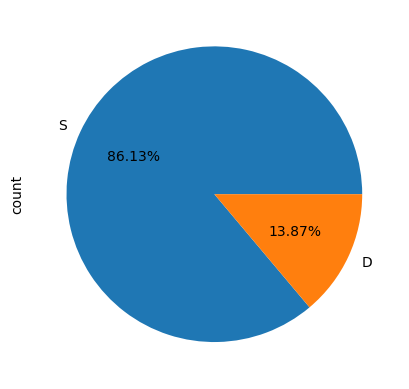

In [111]:
cdcdata_unb["Diabetes_binary"].value_counts().plot.pie(autopct="%.2f%%")

Possiamo vedere come in questo caso le due classi risultano molto sbilanciate, e la maggior parte delle istanze appartiene alla classe dei pazienti sani.

Il dataset ha la stessa struttura riscontrata nella precedente analisi esplorativa, dunque procediamo direttamente con la selezione delle istanze di training.

In [112]:
y_unb = cdcdata_unb["Diabetes_binary"]
X_unb = cdcdata_unb.drop(columns=["Diabetes_binary"])

X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(
    X_unb, y_unb,
    test_size=1/3,
    random_state=42
)

Lo sbilanciamento delle due classi riscontrato in questo dataset può essere problematico in fase di training, in quanto il modello potrebbe privilegiare la classe più rappresentata, commettendo molti più errori di predizione sull'altra.

Per risolvere questo problema, è opportuno applicare, sui dati del training set, una tecnica di bilanciamento dei dati, in modo da eliminare oppure ridurre il divario di cardinalità tra le classi. Nel corso di questa prova, proveremo ad utilizzare due tecniche di bilanciamento: SMOTE per l'oversampling dei dati e NearMiss per l'undersampling.

Per verificare quale delle due tecniche restituisca i risultati migliori, proveremo ad addestrare sui rispettivi training set i due migliori modelli riscontrati nel corso dell'analisi sul dataset bilanciato: XGBoost e Polynomial Logistic Regression con Elasticnet.

Innanzitutto, generiamo i due training set bilanciati, utilizzando le due tecniche.

In [113]:
y_train_unb.value_counts()

Diabetes_binary
S    40160
D     6506
Name: count, dtype: int64

In [114]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_unb, y_train_unb)

In [115]:
y_train_sm.value_counts()

Diabetes_binary
D    40160
S    40160
Name: count, dtype: int64

SMOTE ha generato nuovi dati artificiali per la classe dei pazienti diabetici, pareggiando il numero di istanze per ciascuna classe.

In [116]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_resample(X_train_unb, y_train_unb)

In [117]:
y_train_nm.value_counts()

Diabetes_binary
D    6506
S    6506
Name: count, dtype: int64

Near Miss, invece, ha ridotto il numero delle istanze di pazienti sani, portandolo allo stesso numero della classe dei diabetici. La rimozione delle istanze da parte di Near Miss non è casuale, ma si basa su un algoritmo che rimuove le istanze della classe più numerosa in base alla loro distanza da un certo numero di istanze della classe meno numerosa. Questo criterio dovrebbe ridurre la perdita di informazione derivata dalla rimozione delle istanze della classe più numerosa.

### Training su dataset sbilanciato

Addestriamo entrambi i modelli sul dataset sbilanciato, considerando gli iperparametri migliori trovati nella fase precedente di analisi.

In [118]:
xgb_class_map = {
    "D":1,
    "S":0
}

y_test_unb_xgb = y_test_unb.map(xgb_class_map)
y_train_unb_xgb = y_train_unb.map(xgb_class_map)
y_train_sm_xgb = y_train_sm.map(xgb_class_map)
y_train_nm_xgb = y_train_nm.map(xgb_class_map)

In [119]:
poly_logreg_elastnet.best_params_

{'logreg__C': 0.01,
 'logreg__l1_ratio': 0.5,
 'logreg__penalty': 'elasticnet',
 'poly__degree': 2}

In [120]:
grid_logreg = {
    "logreg__C":[0.01],
    "logreg__l1_ratio":[0.5],
    "logreg__penalty":["elasticnet"],
    "poly__degree":[2]
}
poly_logreg_elastnet_unb = create_poly_logreg_gs(grid_logreg, class_weight="balanced")
poly_logreg_elastnet_unb.fit(X_train_unb, y_train_unb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('logreg',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'logreg__C': [0.01], 'logreg__l1_ratio': [0.5],
                         'logreg__penalty': ['elasticnet'],
                         'poly__degree': [2]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [121]:
xgboost.best_params_

{'xgboost__max_depth': 3,
 'xgboost__n_estimators': 200,
 'xgboost__reg_alpha': 10.0}

In [122]:
grid_xgboost = {
    'xgboost__max_depth': [3],
    'xgboost__n_estimators': [200],
    'xgboost__reg_alpha': [10.0]
}
xgboost_unb = create_xgboost_gs(grid_xgboost)
xgboost_unb.fit(X_train_unb, y_train_unb_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'xgboost__max_depth': [3],
                         'xgboost__n_estimators': [200],
                         'xgboost__reg_alpha': [10.0]},
             scoring='f1')

In [123]:
poly_logreg_elastnet_unb.score(X_test_unb, y_test_unb)

0.4373383899327702

In [124]:
xgboost_unb.score(X_test_unb, y_test_unb_xgb)

0.2710169087878066

In [125]:
y_pred_logreg = poly_logreg_elastnet_unb.predict(X_test_unb)
f1_score(y_test_unb, y_pred_logreg, average="macro")

0.6255875774451394

In [126]:
show_recall_precision(y_test_unb, y_pred_logreg, poly_logreg_elastnet_unb.classes_)

,Precision,Recall
D,0.302060,0.792070
S,0.955407,0.708807


In [127]:
y_pred_xgboost = xgboost_unb.predict(X_test_unb)
f1_score(y_test_unb_xgb, y_pred_xgboost, average="macro")

0.599470403109437

In [128]:
show_recall_precision(y_test_unb_xgb, y_pred_xgboost, xgboost_unb.classes_)

,Precision,Recall
0,0.882084,0.978789
1,0.571285,0.177646


Vediamo come entrambi i modelli hanno una f1 measure più ridotta, dovuta al fatto che lo sbilanciamento verso la classe dei pazienti sani li porta a privilegiare tale classe. Questo è particolarmente evidente nel caso di XGBoost, dove la recall per la classe dei diabetici è scesa allo 0.17. L'effetto è mitigato nella Regressione Logistica grazie al fatto che è stato aggiunto l'iperparametro class_weight="balanced", in modo da assegnare pesi diversi alle due classi.

### Training su dataset bilanciato con SMOTE

In [129]:
poly_logreg_elastnet_sm = create_poly_logreg_gs(grid_logreg)
poly_logreg_elastnet_sm.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid={'logreg__C': [0.01], 'logreg__l1_ratio': [0.5],
                         'logreg__penalty': ['elasticnet'],
                         'poly__degree': [2]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [130]:
xgboost_sm = create_xgboost_gs(grid_xgboost)
xgboost_sm.fit(X_train_sm, y_train_sm_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'xgboost__max_depth': [3],
                         'xgboost__n_estimators': [200],
                         'xgboost__reg_alpha': [10.0]},
             scoring='f1')

In [131]:
poly_logreg_elastnet_sm.score(X_test_unb, y_test_unb)

0.40374208933321104

In [132]:
xgboost_sm.score(X_test_unb, y_test_unb_xgb)

0.3962228870605834

In [133]:
y_pred_logreg = poly_logreg_elastnet_sm.predict(X_test_unb)
f1_score(y_test_unb, y_pred_logreg, average="macro")

0.6109861012862057

In [134]:
show_recall_precision(y_test_unb, y_pred_logreg, poly_logreg_elastnet_unb.classes_)

,Precision,Recall
D,0.285844,0.687168
S,0.935909,0.726839


In [135]:
y_pred_xgboost = xgboost_sm.predict(X_test_unb)
f1_score(y_test_unb_xgb, y_pred_xgboost, average="macro")

0.6083471824383313

In [136]:
show_recall_precision(y_test_unb_xgb, y_pred_xgboost, xgboost_unb.classes_)

,Precision,Recall
0,0.931570,0.733049
1,0.282797,0.661567


Nel dataset bilanciato con SMOTE, i risultati non migliorano di molto. In particolare, vediamo che sulla Logistic Regression, la f1 measure è più bassa rispetto al caso sbilanciato. Nel caso dell'XGBoost, invece, il risultato migliora leggermente, e aumenta anche la Recall della classe dei pazienti diabetici, sebbene il valore rimanga pittosto ridotto.

### Training su dataset bilanciato con Near Miss

In [137]:
poly_logreg_elastnet_nm = create_poly_logreg_gs(grid_logreg)
poly_logreg_elastnet_nm.fit(X_train_nm, y_train_nm)

C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alessandro\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: Con

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('logreg',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             param_grid={'logreg__C': [0.01], 'logreg__l1_ratio': [0.5],
                         'logreg__penalty': ['elasticnet'],
                         'poly__degree': [2]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=D))

In [138]:
xgboost_nm = create_xgboost_gs(grid_xgboost)
xgboost_nm.fit(X_train_nm, y_train_nm_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'xgboost__max_depth': [3],
                         'xgboost__n_estimators': [200],
                         'xgboost__reg_alpha': [10.0]},
             scoring='f1')

In [139]:
poly_logreg_elastnet_nm.score(X_test_unb, y_test_unb)

0.336675185112378

In [140]:
xgboost_nm.score(X_test_unb, y_test_unb_xgb)

0.2892194115731191

In [141]:
y_pred_logreg = poly_logreg_elastnet_nm.predict(X_test_unb)
f1_score(y_test_unb, y_pred_logreg, average="macro")

0.5071792520588476

In [142]:
show_recall_precision(y_test_unb, y_pred_logreg, poly_logreg_elastnet_unb.classes_)

,Precision,Recall
D,0.213054,0.802061
S,0.943774,0.528637


In [143]:
y_pred_xgboost = xgboost_nm.predict(X_test_unb)
f1_score(y_test_unb_xgb, y_pred_xgboost, average="macro")

0.41282467427767333

In [144]:
show_recall_precision(y_test_unb_xgb, y_pred_xgboost, xgboost_unb.classes_)

,Precision,Recall
0,0.933580,0.376335
1,0.175044,0.831720


Utilizzando Near Miss, vediamo che le prestazioni di entrambi i modelli peggiorano ulteriormente. Questo potrebbe essere dovuto al fatto che, malgrado il training set sia bilanciato, la sua dimensione è molto più piccola rispetto al test set. Il set di training, quindi, può risultare poco significativo a livello statistico, limitando la capacità di generalizzazione dei modelli.

### Considerazioni sul test con dataset sbilanciato

Un risultato interessante emerso con questi test è il fatto che, per la Regressione Logistica Polinomiale con Elasticnet, il punteggio migliore si è riscontrato senza applicare nessuna tecnica di sampling, ma semplicemente bilanciando il peso delle classi. Questo potrebbe essere dovuto al fatto che il training set sbilanciato rappresenta meglio il test set. Dunque, con gli iperparametri opportuni, il modello è comunque in grado di generalizzare a partire dal training set sbilanciato. Inoltre, l'oversampling dei dati con SMOTE potrebbe falsare le caratteristiche del training set, generando un insieme di dati troppo diverso rispetto al dataset effettivo.

Nel caso dell'XGBoost, invece, vediamo che il bilanciamento con SMOTE fa aumentare leggermente le performance. Tuttavia, se si introducesse un bilanciamento delle classi anche per questo modello, probabilmente i risultati sarebbero simili a quanto osservato con la Regressione Logistica Polinomiale.

Infine, il bilanciamento basato su undersampling non è risultato efficace, perché rende il training set poco statisticamente significativo rispetto al test set.

## Conclusioni

Nel corso dell'analisi, sono stati testati diversi metodi di machine learning per la classificazione di istanze in un dataset binario. Grazie a questi test, è stato possibile ottenere diversi modelli di classificazione adeguati allo scopo dell'analisi, e che hanno mostrato risultati soddisfacenti.

Inoltre, l'analisi del dataset ha consentito di capire quali sono i fattori più importanti per effettuare una diagnosi accurata sulle istanze considerate.